In [1]:
# python 3.7
# contact@leonardofilipe.com

%matplotlib notebook
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from scipy.interpolate    import Rbf
from matplotlib           import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

db             = pd.read_hdf("optiondata.h5")
db             = db.drop('index',axis=1)
db['Now']      = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
N0  = db[db['Now'] == '2018-04-17 14:30:00']
M00 = N0[N0['Maturity'] == '2018-06-15 17:30:00']
M00[M00['CallImpVol'] < 0.001] = 0
M00 = M00.loc[(M00!=0).any(1)]
M00 = M00.reset_index().drop('index',axis=1)
M00['Moneyness'] = abs(M00['Strike']/M00['Spot'])

N1  = db[db['Now'] == '2018-04-17 14:35:00']
M01 = N1[N1['Maturity'] == '2018-06-15 17:30:00']
M01[M01['CallImpVol'] < 0.001] = 0
M01 = M01.loc[(M01!=0).any(1)]
M01 = M01.reset_index().drop('index',axis=1)
M01['Moneyness'] = abs(M01['Strike']/M01['Spot'])

<IPython.core.display.Javascript object>


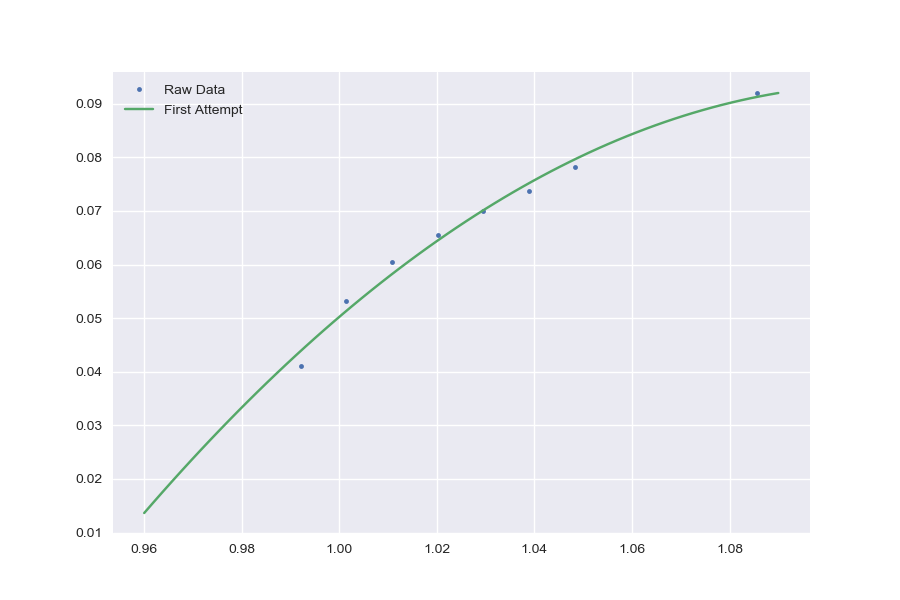

In [3]:
p = np.poly1d(np.polyfit(M00['Moneyness'], M00['CallImpVol'], 2))

xp = np.linspace(0.96, 1.09, 68)

plt.figure(figsize=(9,6))
plt.plot(M00['Moneyness'], M00['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.legend()
plt.show()

So obviously implied volatility is related to the moneyness of the contracts but that's not the only driver, maturity also plays an important role, as they move closer to it, they gain leverage and thats also displayed on the implied volatility. This polynomial also seems to exarcebate the implied volatility of the deeper in & out of the money contracts

In [4]:
splinterp = Rbf(M00['Moneyness'], M00['Expiration'], M00['CallImpVol'], function='cubic', smooth=0)

And probably we're gonna need a more robust method to deal with the outliers and add the time factor, we'll have to use a multivariate (3d) polynomial fit or a multivariate spline interpolation, I decided to try the radial basis function to perform the latter, despite not having an appropriate sample to describe the effects of time on the implied volatility since that would require at least 1 month of option data

In [5]:
# Testing the model a month later
db2 = pd.read_hdf("moreoptiondata.h5")
db2['Now'] = pd.to_datetime(db2['Now'])
db2['Maturity'] = pd.to_datetime(db2['Maturity'])

M0 = db2[db2['Maturity'] == '2018-06-15 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

<IPython.core.display.Javascript object>


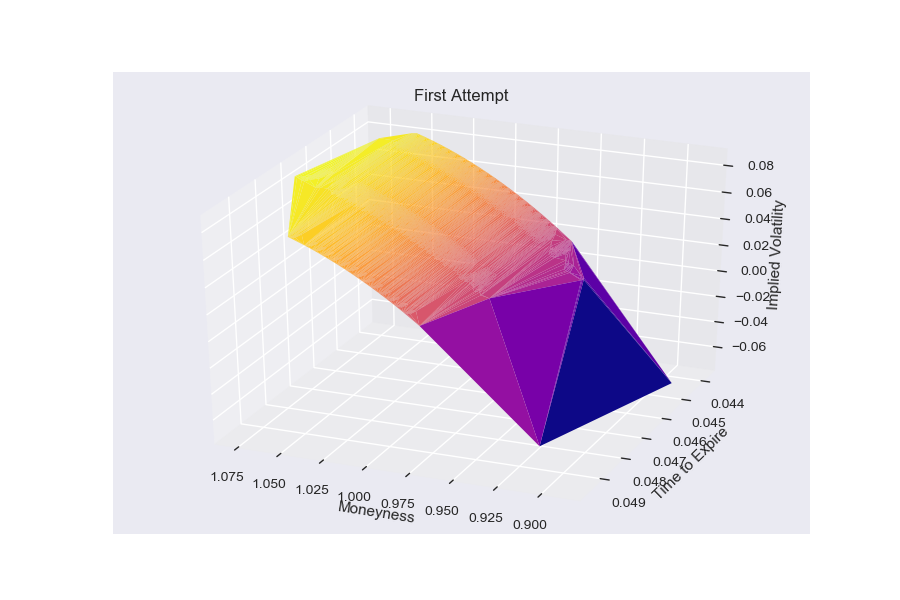

In [6]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(M0['Moneyness'], M0['Expiration'],
                p(M0['Moneyness']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 112.5)
plt.title('First Attempt')
plt.show()

Not suitable at all, we are gonna need a more robust method or to perform some kind of smoothing on the edges and to update the model itself across time

<IPython.core.display.Javascript object>


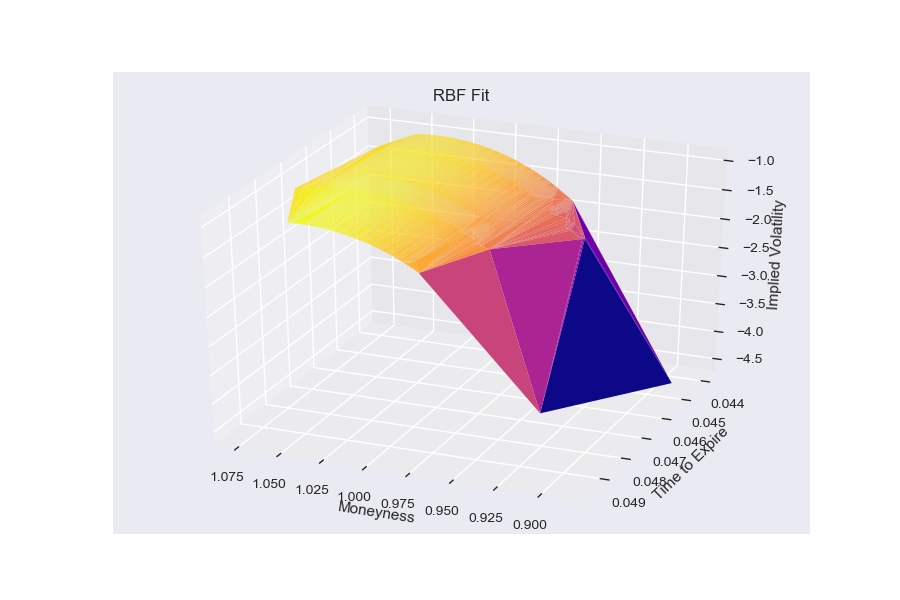

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(M0['Moneyness'], M0['Expiration'],
                splinterp(M0['Moneyness'], M0['Expiration']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expire')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 112.5)
plt.title('RBF Fit')
plt.show()

And the radial basis function is gonna require a model to build the surface from otherwise it will just replicate the past

In [8]:
def func(a,b):
    error = ['']*len(M01['Moneyness'][:-3])
    for x, name in enumerate(M01['Moneyness'][:-3]):
        error[x] = ((M01['Moneyness'][:-3][x]/M00['Moneyness'][:-1][x]-1)*a+
                    (M01['Expiration'][:-3][x]/M00['Expiration'][:-1][x]-1)*b+
                    M00['CallImpVol'][:-1][x])-M01['CallImpVol'][:-3][x]
    return pd.Series(error).mean()

In [9]:
a = 1
b = 1.5

error = ['']*len(M01['Moneyness'][:-3])
for x, name in enumerate(M01['Moneyness'][:-3]):
    error[x] = ((M01['Moneyness'][:-3][x]/M00['Moneyness'][:-1][x]-1)*a+
                (M01['Expiration'][:-3][x]/M00['Expiration'][:-1][x]-1)*b+
                M00['CallImpVol'][:-1][x])-M01['CallImpVol'][:-3][x]
    
M01['PredictCallImpVol'] = ((M01['Moneyness'][:-3][x]/M00['Moneyness'][:-1][x]-1)*a+
                            (M01['Expiration'][:-3][x]/M00['Expiration'][:-1][x]-1)*b+
                            M00['CallImpVol'][:-1][x])

In [10]:
pd.DataFrame({'1':M00['Strike'],'2':M01['Strike'],'3':M00['CallImpVol'],'4':M01['CallImpVol'],
             '5':M00['Expiration'],'6':M01['Expiration'],'7':M00['Moneyness'],'8':M01['Moneyness']})

,1,2,3,4,5,6,7,8
0,5300.0,5300.0,0.041133,0.040427,0.161986,0.161977,0.992101,0.991729
1,5350.0,5350.0,0.053175,0.052930,0.161986,0.161977,1.001460,1.001085
2,5400.0,5400.0,0.060451,0.059916,0.161986,0.161977,1.010820,1.010441
3,5450.0,5450.0,0.065568,0.065019,0.161986,0.161977,1.020179,1.019797
4,5500.0,5500.0,0.070026,0.069521,0.161986,0.161977,1.029538,1.029153
5,5550.0,5550.0,0.073787,0.073515,0.161986,0.161977,1.038898,1.038509
6,5600.0,5600.0,0.078115,0.077459,0.161986,0.161977,1.048257,1.047865
7,5800.0,5650.0,0.092002,0.080405,0.161986,0.161977,1.085695,1.057221
8,NaN,5700.0,NaN,0.083454,NaN,0.161977,NaN,1.066577
9,NaN,5800.0,NaN,0.091640,NaN,0.161977,NaN,1.085289
